# **Spectral Clustering for OnlineRetail and ShillBidding data** 

**Data Pre-Processing** (Rerfer 'OnlineRetail' file)

In [21]:
import pandas as pd
retail = "../data/Online Retail.xlsx" # use this for using local data within the repo.
df_onlineRetail = pd.read_excel(retail, sheet_name='Online Retail')
df_onlineRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [22]:
url = "../data/Shill Bidding Dataset.csv" # use local dataset within the repo instead.

# Load into a DataFrame
df_shillBidding = pd.read_csv(url)

# Convert Record_ID to object  
df_shillBidding['Record_ID'] = df_shillBidding['Record_ID'].astype(str)

# Convert Auction_ID to object  
df_shillBidding['Auction_ID'] = df_shillBidding['Auction_ID'].astype(str)

# Set Record_ID as index  
df_shillBidding.set_index('Record_ID', inplace=True)

# Remove Class variable from data - save for later use
target = df_shillBidding['Class']
df_shillBidding = df_shillBidding.drop(['Class'], axis=1)
df_shillBidding.head()

,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration
Record_ID,,,,,,,,,,,
1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5
2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5
3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5
4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5
5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7


In [23]:
print("df_onlineRetail data size", df_onlineRetail.shape)
print("df_shillBidding data size", df_shillBidding.shape)

df_onlineRetail data size (541909, 8)
df_shillBidding data size (6321, 11)


In [24]:
#Check dataframe for missing values
print("df_onlineRetail missing values: ", df_onlineRetail.isnull().sum())
print("df_shillBidding missing values: ", df_shillBidding.isnull().sum())

df_onlineRetail missing values:  InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
df_shillBidding missing values:  Auction_ID                0
Bidder_ID                 0
Bidder_Tendency           0
Bidding_Ratio             0
Successive_Outbidding     0
Last_Bidding              0
Auction_Bids              0
Starting_Price_Average    0
Early_Bidding             0
Winning_Ratio             0
Auction_Duration          0
dtype: int64


**Drop missing values**

In [25]:
# Drop missing Customer IDs and Description
df_onlineRetail.dropna(subset=["CustomerID", "Description"], inplace=True)
df_onlineRetail.shape

(406829, 8)

In [26]:
df_onlineRetail["InvoiceDate"] = pd.to_datetime(df_onlineRetail["InvoiceDate"])
df_onlineRetail["InvoiceNo"] = df_onlineRetail["InvoiceNo"].astype(str)
df_onlineRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Filtering Out Invalid Transactions**

In [27]:
# Remove negative or zero values in Quantity and UnitPrice
df_onlineRetail = df_onlineRetail[(df["Quantity"] > 0) & (df_onlineRetail["UnitPrice"] > 0)]

<ipython-input-27-9d0eb8ad663f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_onlineRetail = df_onlineRetail[(df["Quantity"] > 0) & (df_onlineRetail["UnitPrice"] > 0)]


## **Create RFM Dataframe** (Rerfer 'OnlineRetail' file)

In [28]:
df_onlineRetaildf = df_onlineRetail.copy()

# Compute the latest transaction date in the dataset
latest_date = df_onlineRetail["InvoiceDate"].max()

# Create "TotalPrice" column manually using .loc to avoid warning
df_onlineRetail.loc[:, "TotalPrice"] = df_onlineRetail["Quantity"] * df_onlineRetail["UnitPrice"]

# Compute RFM metrics for each customer
rfm = df_onlineRetail.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (latest_date - x.max()).days),  # Days since last purchase
    Frequency=("InvoiceNo", "nunique"),  # Count of unique transactions
    Monetary=("TotalPrice", "sum")  # Total spending amount
).reset_index()  # Reset index

# Display the first five rows
rfm.head()

# Use MinMaxScaler for normalizing the original dataset to be used
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Apply log transformation (adding 1 to avoid log(0) issues)
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to Recency, Frequency, and Monetary
rfm_norm = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

# Convert the result back into a DataFrame
rfm_minmax= pd.DataFrame(rfm_norm, columns=['Recency', 'Frequency', 'Monetary'])


**Dimension Reduction Usng PCA**

In [32]:
import pandas as pd
from sklearn.decomposition import PCA

# Apply PCA analysis on dataset that normalized using MinMaxscalar
# This would be used for all algorithm except DBSCAN
# Apply pca on datafram using 2 compopnents
pca_minmax = PCA(n_components=2)
rfm_reduced = pca_minmax.fit_transform(rfm_minmax)

# Convert the PCA output to a DataFrame
rfm_df = pd.DataFrame(rfm_reduced, columns=["PCA1", "PCA2"])

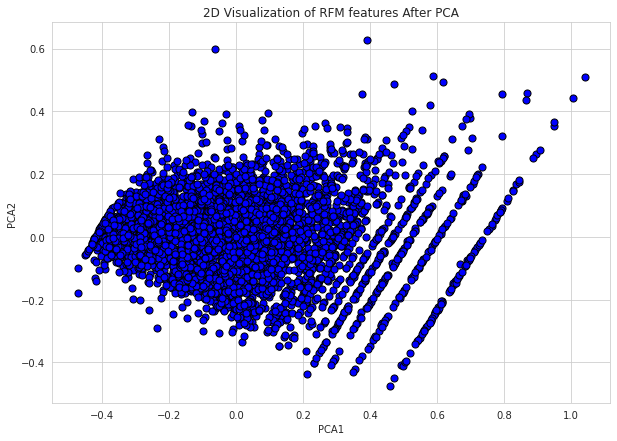

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create a 2D scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(rfm_df["PCA1"], rfm_df["PCA2"], s=50, edgecolor='k', color='blue')

# Labels and title
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("2D Visualization of RFM features After PCA")

# Show the plot
plt.show()

In [42]:
from sklearn.cluster import SpectralClustering, DBSCAN, Birch
cluster_results = {}
validation_scores = {}
# "Spectral Clustering"
algorithm = SpectralClustering(n_clusters=3, affinity='rbf', random_state=42)
labels = algorithm.fit_predict(rfm_df)
cluster_results["Spectral Clustering"] = labels

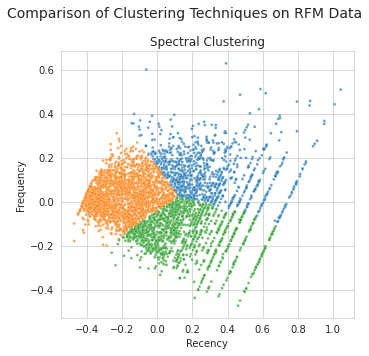

In [56]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# Compute validation metrics for each clustering method
for name, labels in cluster_results.items():
    data = rfm_df
    if len(set(labels)) > 1:  # Silhouette Score requires at least 2 clusters
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = -1  # Assign -1 when only one cluster exists to avoid errors

    # Compute Davies-Bouldin Index (lower is better)
    db_index = davies_bouldin_score(data, labels)

    # Compute Calinski-Harabasz Index (higher is better)
    ch_index = calinski_harabasz_score(data, labels)

    # Store validation scores in a dictionary
    validation_scores[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }
validation_scores
num_clusters = 1
fig, axes = plt.subplots(1, num_clusters, figsize=(5 * num_clusters, 5))
fig.suptitle("Comparison of Clustering Techniques on RFM Data", fontsize=14)
if num_clusters == 1:
    axes = [axes]

# Iterate through the clustering results and visualize the clusters
for i, (name, labels) in enumerate(cluster_results.items()):
    unique_labels = len(set(labels))  # Get number of unique clusters
    palette = sns.color_palette("tab10", n_colors=unique_labels)  # Define color palette

    # Scatter plot for visualizing clustering on Recency vs Frequency
    sns.scatterplot(
        x=rfm_df["PCA1"],  # X-axis: Recency
        y=rfm_df["PCA2"],  # Y-axis: Frequency
        hue=labels,  # Color clusters by labels
        palette=palette,  # Use color palette based on unique labels
        alpha=0.7,  # Set transparency for better visibility
        s=8,  # Set point size
        ax=axes[i]  # Assign plot to the respective subplot
    )

    # Set plot title and axis labels
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Recency")
    axes[i].set_ylabel("Frequency")

    # Remove legends from each subplot to avoid redundancy
    axes[i].legend([], frameon=False)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plots
plt.show()
